In [4]:
# --- 1. Import Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# --- 2. Load and Initial Cleaning ---

# Define the file path for easy configuration.
FILE_PATH = '/Users/selim/Desktop/Projects/Python Projects/Employee Project/datas/raw/Messy_Employee_dataset.csv'


# Load the dataset.
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: The file was not found at {FILE_PATH}")
    exit()

# Remove any fully duplicate rows from the dataset.
df.drop_duplicates(inplace=True)

In [6]:
# --- 3. Data Transformation and Wrangling ---

# Clean and standardize individual columns.
df['Age'] = df['Age'].round(0)
df['Join_Date'] = pd.to_datetime(df['Join_Date'], format='%m/%d/%Y')
df['Phone'] = df['Phone'].astype(str).apply(lambda x: f"{x[1:5]}-{x[5:8]}-{x[8:11]}")

# Split the combined 'Department_Region' column into two separate columns.
df[['department', 'location']] = df['Department_Region'].str.split('-', expand=True)

# Drop the original, now redundant, column.
df.drop(columns='Department_Region', inplace=True)

# Rename columns to a consistent snake_case format for easier access.
df.rename(columns={
    'Employee_ID': 'employee_id',
    'First_Name': 'first_name',
    'Last_Name': 'last_name',
    'Age': 'age',
    'Status': 'status',
    'Join_Date': 'full_date',
    'Salary': 'salary',
    'Email': 'email',
    'Phone': 'phone',
    'Performance_Score': 'performance',
    'Remote_Work': 'remote_work'
}, inplace=True)

In [7]:
# --- 4. Data Modeling: Create Dimension Tables ---

# The following steps create individual, unique tables for different dimensions of the data,
# which is a standard practice for preparing data for analysis and BI tools (star schema).

# --- 4.1 Dimension: Employee ---
dim_employee = df[['employee_id', 'first_name', 'last_name', 'age', 'email', 'phone', 'remote_work']].drop_duplicates().reset_index(drop=True)
dim_employee['employee_key'] = dim_employee.index + 1 # Create a unique surrogate key.

# --- 4.2 Dimension: Department ---
dim_department = df[['department']].drop_duplicates().reset_index(drop=True)
dim_department['department_key'] = dim_department.index + 1

# --- 4.3 Dimension: Location ---
dim_location = df[['location']].drop_duplicates().reset_index(drop=True)
dim_location['location_key'] = dim_location.index + 1

# --- 4.4 Dimension: Status ---
dim_status = df[['status']].drop_duplicates().reset_index(drop=True)
dim_status['status_key'] = dim_status.index + 1

# --- 4.5 Dimension: Performance ---
dim_performance = df[['performance']].drop_duplicates().reset_index(drop=True)
# Map performance strings to a numerical score (surrogate key).
performance_map = {'Poor': 1, 'Average': 2, 'Good': 3, 'Excellent': 4}
dim_performance['performance_key'] = dim_performance['performance'].map(performance_map)

# --- 4.6 Dimension: Date ---
dim_date = df[['full_date']].drop_duplicates().sort_values(by='full_date').reset_index(drop=True)
dim_date['date_key'] = dim_date['full_date'].dt.strftime('%Y%m%d').astype(int)
dim_date['year'] = dim_date['full_date'].dt.year
dim_date['quarter'] = dim_date['full_date'].dt.quarter
dim_date['month'] = dim_date['full_date'].dt.month
dim_date['day'] = dim_date['full_date'].dt.day
dim_date['day_of_week'] = dim_date['full_date'].dt.day_name()




In [8]:
# --- 5. Verification ---
print("--- Main DataFrame Head ---")
print(df.head())
print("\n--- Dimension: Employee ---")
print(dim_employee.head())
print("\n--- Dimension: Date ---")
print(dim_date.head())
print("\n--- Dimension: Performance ---")
print(dim_performance.head())

--- Main DataFrame Head ---
  employee_id first_name last_name   age    status  full_date     salary  \
0     EMP1000        Bob     Davis  25.0    Active 2021-04-02   59767.65   
1     EMP1001        Bob     Brown   NaN    Active 2020-07-10   65304.66   
2     EMP1002      Alice     Jones   NaN   Pending 2023-12-07   88145.90   
3     EMP1003        Eva     Davis  25.0  Inactive 2021-11-27   69450.99   
4     EMP1004      Frank  Williams  25.0    Active 2022-01-05  109324.61   

                        email         phone performance  remote_work  \
0       bob.davis@example.com  1651-623-197     Average         True   
1       bob.brown@example.com  1898-471-390   Excellent         True   
2     alice.jones@example.com  5596-363-211        Good         True   
3       eva.davis@example.com  3476-490-784        Good         True   
4  frank.williams@example.com  1586-734-256        Poor        False   

   department    location  
0      DevOps  California  
1     Finance       Texas 

In [9]:
# --- 6. Data Modeling: Create the Fact Table ---

# The fact table connects all the dimension tables using their surrogate keys.
# It contains the primary business measurements (facts), like 'salary'.

# Start with a copy of the cleaned and transformed main DataFrame.
fact_table = df.copy()

# Join the fact table with each dimension table to look up the surrogate keys.
# A left merge is used to ensure all original records are kept.
fact_table = pd.merge(fact_table, dim_employee, on=['employee_id', 'first_name', 'last_name', 'age', 'email', 'phone', 'remote_work'], how='left')
fact_table = pd.merge(fact_table, dim_department, on='department', how='left')
fact_table = pd.merge(fact_table, dim_location, on='location', how='left')
fact_table = pd.merge(fact_table, dim_status, on='status', how='left')
fact_table = pd.merge(fact_table, dim_performance, on='performance', how='left')
fact_table = pd.merge(fact_table, dim_date, on='full_date', how='left')

# Select only the surrogate keys and the factual measures to create the final fact table.
fact_employee_performance = fact_table[[
    'employee_key',
    'date_key',
    'department_key',
    'location_key',
    'status_key',
    'performance_key',
    'salary'  # The primary measure or "fact"
]].copy()

In [10]:
# --- 7. Save All DataFrames to CSV ---

# Define a base output path to keep the code clean and easy to modify.
OUTPUT_PATH = '/Users/selim/Desktop/Projects/Python Projects/Employee Project/datas/final/'

# Create a dictionary mapping each DataFrame to its desired filename.
# This approach is organized and easily scalable if more tables are added.
files_to_save = {
    'main_employee_data.csv': df,
    'dim_employee.csv': dim_employee,
    'dim_department.csv': dim_department,
    'dim_location.csv': dim_location,
    'dim_status.csv': dim_status,
    'dim_performance.csv': dim_performance,
    'dim_date.csv': dim_date,
    'fact_employee_performance.csv': fact_employee_performance
}

# Loop through the dictionary to save each file.
# `index=False` is crucial to prevent writing the DataFrame index as a column.
print("\n--- Saving all data files ---")
for filename, dataframe in files_to_save.items():
    try:
        full_path = f"{OUTPUT_PATH}{filename}"
        dataframe.to_csv(full_path, index=False)
        print(f"Successfully saved: {filename}")
    except Exception as e:
        print(f"Error saving {filename}: {e}")

print("\n--- ETL process complete. ---")


--- Saving all data files ---
Successfully saved: main_employee_data.csv
Successfully saved: dim_employee.csv
Successfully saved: dim_department.csv
Successfully saved: dim_location.csv
Successfully saved: dim_status.csv
Successfully saved: dim_performance.csv
Successfully saved: dim_date.csv
Successfully saved: fact_employee_performance.csv

--- ETL process complete. ---


In [11]:
# --- 8. Final Verification ---
print("\n--- Fact Table Head ---")
print(fact_employee_performance.head())
print("\n--- Fact Table Info ---")
fact_employee_performance.info()


--- Fact Table Head ---
   employee_key  date_key  department_key  location_key  status_key  \
0             1  20210402               1             1           1   
1             2  20200710               2             2           1   
2             3  20231207               3             3           2   
3             4  20211127               3             3           3   
4             5  20220105               4             4           1   

   performance_key     salary  
0                2   59767.65  
1                4   65304.66  
2                3   88145.90  
3                3   69450.99  
4                1  109324.61  

--- Fact Table Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   employee_key     1020 non-null   int64  
 1   date_key         1020 non-null   int64  
 2   department_key   1020 non-null   int

# 1. Analysis of High-Performance and High-Cost Employees in Supply Chain Functions
### Business Question: In our most critical supply chain-related departments (e.g., Logistics, Operations, Procurement), what is the correlation between employee salary and performance? Are we adequately rewarding top performers who drive efficiency, and are there high-cost, low-performance outliers that need to be addressed? This will help us ensure that our largest personnel expenses are justified by tangible results in our supply chain operations.
#### Required Columns: department salary performance

In [12]:
# --- 1.1 Data Preparation ---

# Join the fact table with the department and performance dimensions to get the necessary labels.
perform_and_cost = pd.merge(fact_employee_performance, dim_department, on='department_key', how='left')
perform_and_cost = pd.merge(perform_and_cost, dim_performance, on='performance_key', how='left')

# Select only the columns needed for this specific analysis.
perform_and_cost = perform_and_cost[['department', 'salary', 'performance']]

In [13]:
# --- 1.2 Categorise and Sorting ---

# Convert the 'performance' column to an ordered categorical type.
# This ensures the plot legend and any sorting will follow a logical order ('Excellent' > 'Good', etc.).
performance_order = ['Poor', 'Average', 'Good', 'Excellent']
perform_and_cost['performance'] = pd.Categorical(perform_and_cost['performance'], categories=performance_order, ordered=True)

In [14]:
# --- 1.3 Numerical Summary (Optional but Recommended) ---

# A numerical summary provides concrete data to support the visual analysis.
print("--- Median Salary by Department and Performance ---")
salary_summary = perform_and_cost.groupby(['department', 'performance'])['salary'].median().unstack()
print(salary_summary)

--- Median Salary by Department and Performance ---
performance       Poor    Average       Good  Excellent
department                                             
Admin        88000.885  78818.420  87473.690   90499.16
Cloud Tech   80493.155  86618.370  84100.525   89696.07
DevOps       88014.105  86438.160  82318.890   89132.22
Finance      86470.315  79742.000  94010.395   78105.02
HR           78760.835  95127.910  85602.100   84821.72
Sales        91780.040  88048.545  88856.140   82273.08


/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_64750/3249835389.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salary_summary = perform_and_cost.groupby(['department', 'performance'])['salary'].median().unstack()


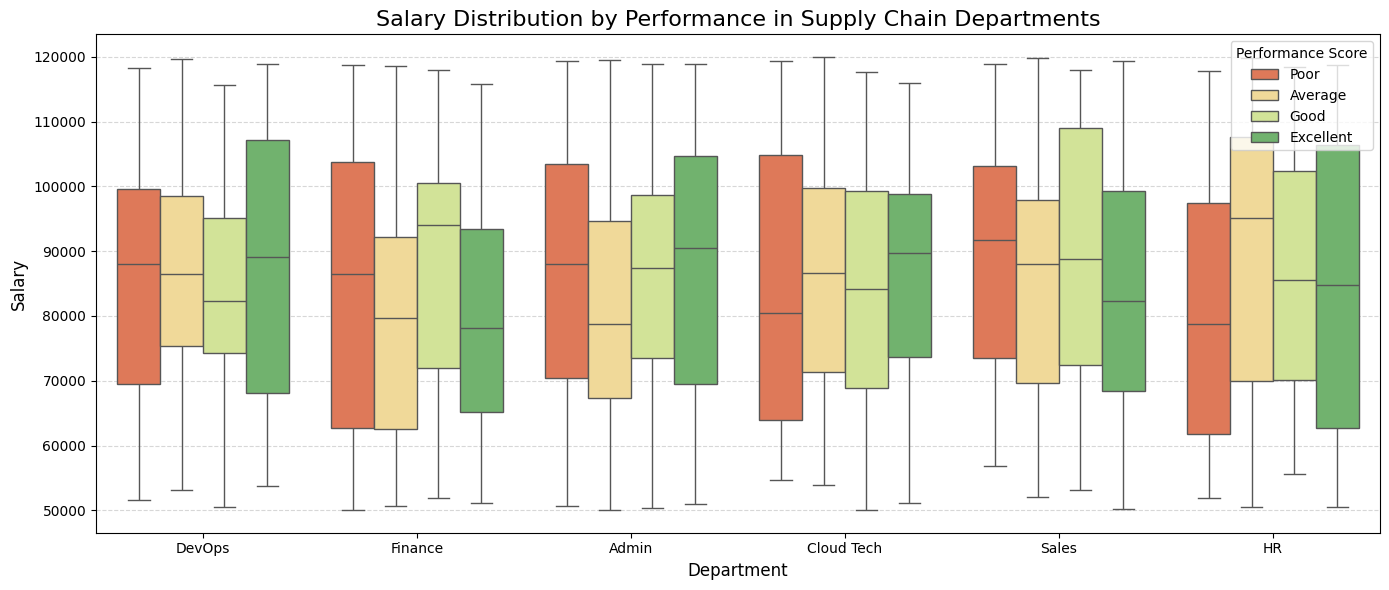

In [15]:
# --- 1.4 Visualization: Salary vs. Performance ---

# A boxplot is ideal for comparing the distribution of salaries across different categories.
plt.figure(figsize=(14, 6))

sns.boxplot(
    data=perform_and_cost,
    x='department',
    y='salary',
    hue='performance',
    hue_order=performance_order, # Use the defined order for the legend
    palette='RdYlGn' # A diverging palette is great for performance data (Red=Poor, Green=Excellent)
)

plt.title('Salary Distribution by Performance in Supply Chain Departments', fontsize=16)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Salary', fontsize=12)
plt.legend(title='Performance Score', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Departmental Salary Expenditure and Headcount Analysis
### Business Question: Which departments have the highest total salary expenditure for "Active" employees? Understanding the distribution of our labor costs across different departments will allow us to pinpoint areas with the most significant financial impact on our supply chain and prioritize them for process optimization and potential headcount review.
#### Required Columns: department salary status


In [16]:
# --- 2.1 Data Preparation for Active Employees ---

# Filter the fact table to include only active employees using the key we found.
active_employees_df = fact_employee_performance[fact_employee_performance['status_key'] == 1]

# Merge with the department dimension to get department names.
active_employees_df = pd.merge(active_employees_df, dim_department, on='department_key', how='left')

# Select only the columns needed for this analysis.
active_employees_df = active_employees_df[['department', 'salary']]

In [17]:
# --- 2.2 Aggregate Salary and Headcount by Department ---

# Group by department and calculate the total salary expenditure and employee count (headcount).
department_summary = active_employees_df.groupby('department')['salary'].agg(
    total_salary='sum',
    headcount='count'
).reset_index()

# Calculate the percentage contribution of each department to the total salary and headcount.
department_summary['pct_salary'] = (department_summary['total_salary'] / department_summary['total_salary'].sum() * 100).round(2)
department_summary['pct_headcount'] = (department_summary['headcount'] / department_summary['headcount'].sum() * 100).round(2)

# Sort by total salary to ensure plots are ordered from highest to lowest expenditure.
department_summary = department_summary.sort_values('total_salary', ascending=False)

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_64750/3497588261.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_64750/3497588261.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


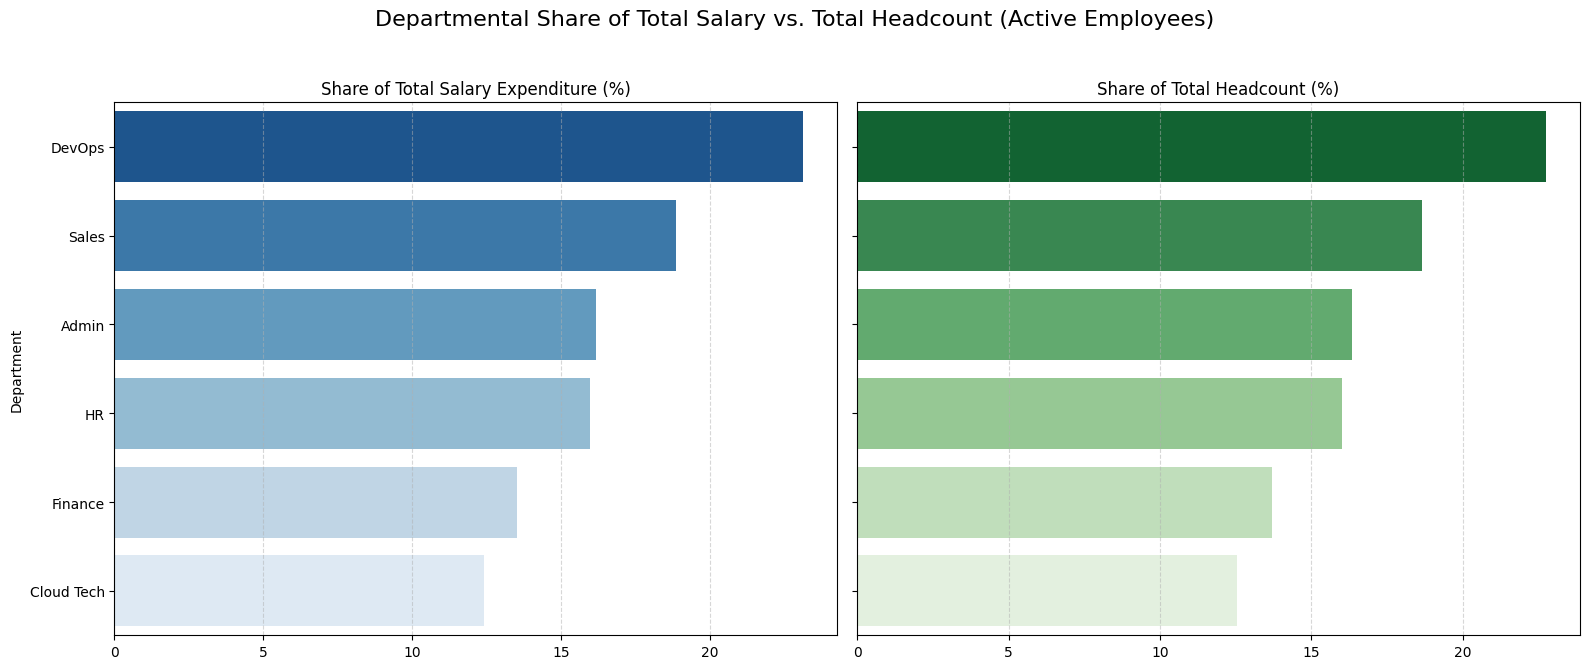

,department,total_salary,headcount,pct_salary,pct_headcount
2,DevOps,6746998.55,78,23.11,22.74
5,Sales,5502857.22,64,18.85,18.66
0,Admin,4723453.11,56,16.18,16.33
4,HR,4660179.77,55,15.96,16.03
3,Finance,3941592.95,47,13.50,13.70
1,Cloud Tech,3624256.21,43,12.41,12.54


In [18]:
# --- 2.3 Visualization: Comparing Salary vs. Headcount Share ---

# Create a figure with two subplots side-by-side to compare the metrics.
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Departmental Share of Total Salary vs. Total Headcount (Active Employees)', fontsize=16)

# --- Plot 1: Share of Total Salary ---
sns.barplot(
    data=department_summary,
    x='pct_salary',
    y='department',
    palette='Blues_r', # "_r" reverses the palette, making the highest value darkest
    ax=axes[0]
)
axes[0].set_title('Share of Total Salary Expenditure (%)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Department')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# --- Plot 2: Share of Total Headcount ---
sns.barplot(
    data=department_summary,
    x='pct_headcount',
    y='department',
    palette='Greens_r',
    ax=axes[1]
)
axes[1].set_title('Share of Total Headcount (%)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('') # The y-axis label is shared from the first plot

axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()


# --- Display the summary data for review ---
department_summary

# 3. Performance Trend Analysis in Key Departments
### Business Question: How has employee performance in our supply chain-related departments trended over the past few years? A decline in performance could be an early indicator of operational inefficiencies, increased errors, or process bottlenecks that are driving up costs within the supply chain.
#### Required Columns: department performance year quarter


In [19]:
# --- 3.1 Data Preparation ---

# Join the fact table with the date and department dimensions.
performance_df = pd.merge(fact_employee_performance, dim_date, on='date_key', how='left')
performance_df = pd.merge(performance_df, dim_department, on='department_key', how='left')

# Create a 'period' column (e.g., '2022-Q1') for clear time-series plotting.
performance_df['period'] = performance_df['year'].astype(str) + '-Q' + performance_df['quarter'].astype(str)

# Select only the columns needed for this analysis.
performance_df = performance_df[['department', 'performance_key', 'period']]

In [20]:
# --- 3.2 Focus on Supply Chain Departments and Aggregate Data ---

# Group by period and department, then calculate the mean performance score.
# This gives us the average performance for each department in each quarter.
trend_summary = performance_df.groupby(['period', 'department'])['performance_key'].agg(
    average_score='mean'
).round(2).reset_index()

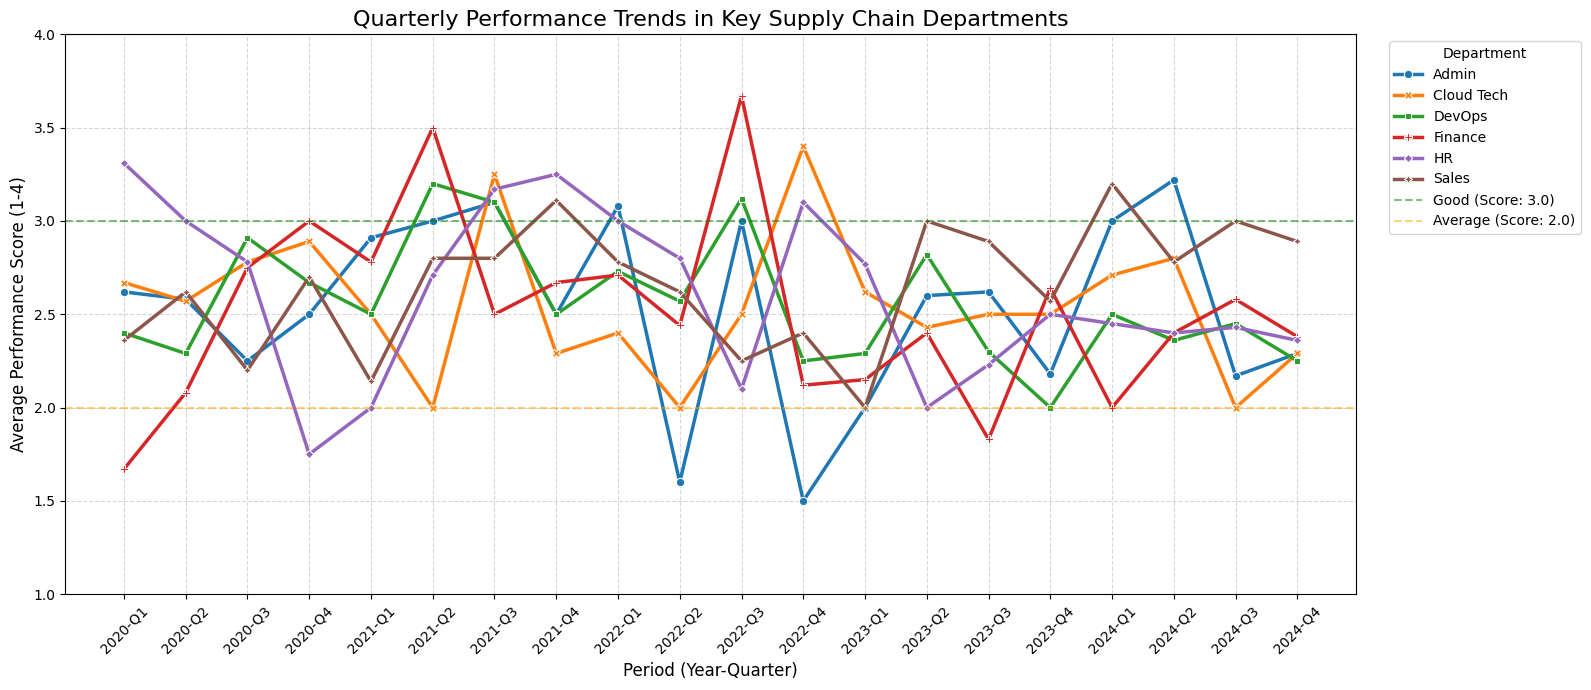

--- Average Performance Score by Quarter and Department ---
department  Admin  Cloud Tech  DevOps  Finance    HR  Sales
period                                                     
2020-Q1      2.62        2.67    2.40     1.67  3.31   2.36
2020-Q2      2.58        2.57    2.29     2.08  3.00   2.62
2020-Q3      2.25        2.78    2.91     2.75  2.78   2.20
2020-Q4      2.50        2.89    2.67     3.00  1.75   2.70
2021-Q1      2.91        2.50    2.50     2.78  2.00   2.14
2021-Q2      3.00        2.00    3.20     3.50  2.71   2.80
2021-Q3      3.10        3.25    3.10     2.50  3.17   2.80
2021-Q4      2.50        2.29    2.50     2.67  3.25   3.11
2022-Q1      3.08        2.40    2.73     2.71  3.00   2.78
2022-Q2      1.60        2.00    2.57     2.44  2.80   2.62
2022-Q3      3.00        2.50    3.12     3.67  2.10   2.25
2022-Q4      1.50        3.40    2.25     2.12  3.10   2.40
2023-Q1      2.00        2.62    2.29     2.15  2.77   2.00
2023-Q2      2.60        2.43    2.82   

In [21]:
# --- 3.3 Visualization: Performance Trends Over Time ---

plt.figure(figsize=(16, 7))

# Create a line plot to visualize the performance trend for each department.
sns.lineplot(
    data=trend_summary,
    x='period',
    y='average_score',
    hue='department',
    style='department', # Use different line styles for each department for accessibility
    marker='o',
    markers=True,
    dashes=False,
    linewidth=2.5
)

# Add horizontal lines to serve as performance benchmarks.
# These lines make it easy to see when a department's performance is 'Good' or 'Average'.
plt.axhline(3, color='green', linestyle='--', alpha=0.5, label='Good (Score: 3.0)')
plt.axhline(2, color='orange', linestyle='--', alpha=0.5, label='Average (Score: 2.0)')

# --- Formatting and Labels ---
plt.title('Quarterly Performance Trends in Key Supply Chain Departments', fontsize=16)
plt.xlabel('Period (Year-Quarter)', fontsize=12)
plt.ylabel('Average Performance Score (1-4)', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(1,4)
plt.legend(title='Department', bbox_to_anchor=(1.02, 1), loc='upper left') # Move legend outside the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()

# --- Display the summary data for review ---
print("--- Average Performance Score by Quarter and Department ---")
print(trend_summary.pivot(index='period', columns='department', values='average_score'))

# 4. Impact of Remote Work on Performance and Cost
### Business Question: Within our supply chain departments, is there a discernible difference in performance and salary between remote and in-office employees? This analysis can inform our long-term strategy for remote work, potentially highlighting opportunities to reduce overhead costs associated with physical office space without compromising the efficiency of our supply chain.
#### Required Columns: department remote_work performance salary

In [22]:
# --- 4.1 Data Preparation ---

# Join the necessary fact and dimension tables.
remote_work_analysis_df = pd.merge(fact_employee_performance, dim_employee, on='employee_key', how='left')
remote_work_analysis_df = pd.merge(remote_work_analysis_df, dim_department, on='department_key', how='left')

# Select only the columns needed for this analysis.
remote_work_analysis_df = remote_work_analysis_df[['department', 'remote_work', 'performance_key', 'salary']]


# For clearer plot legends, map the boolean 'remote_work' to descriptive strings.
remote_work_analysis_df['work_mode'] = remote_work_analysis_df['remote_work'].map({True: 'Remote', False: 'On-Site'})

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_64750/3419801486.py:25: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


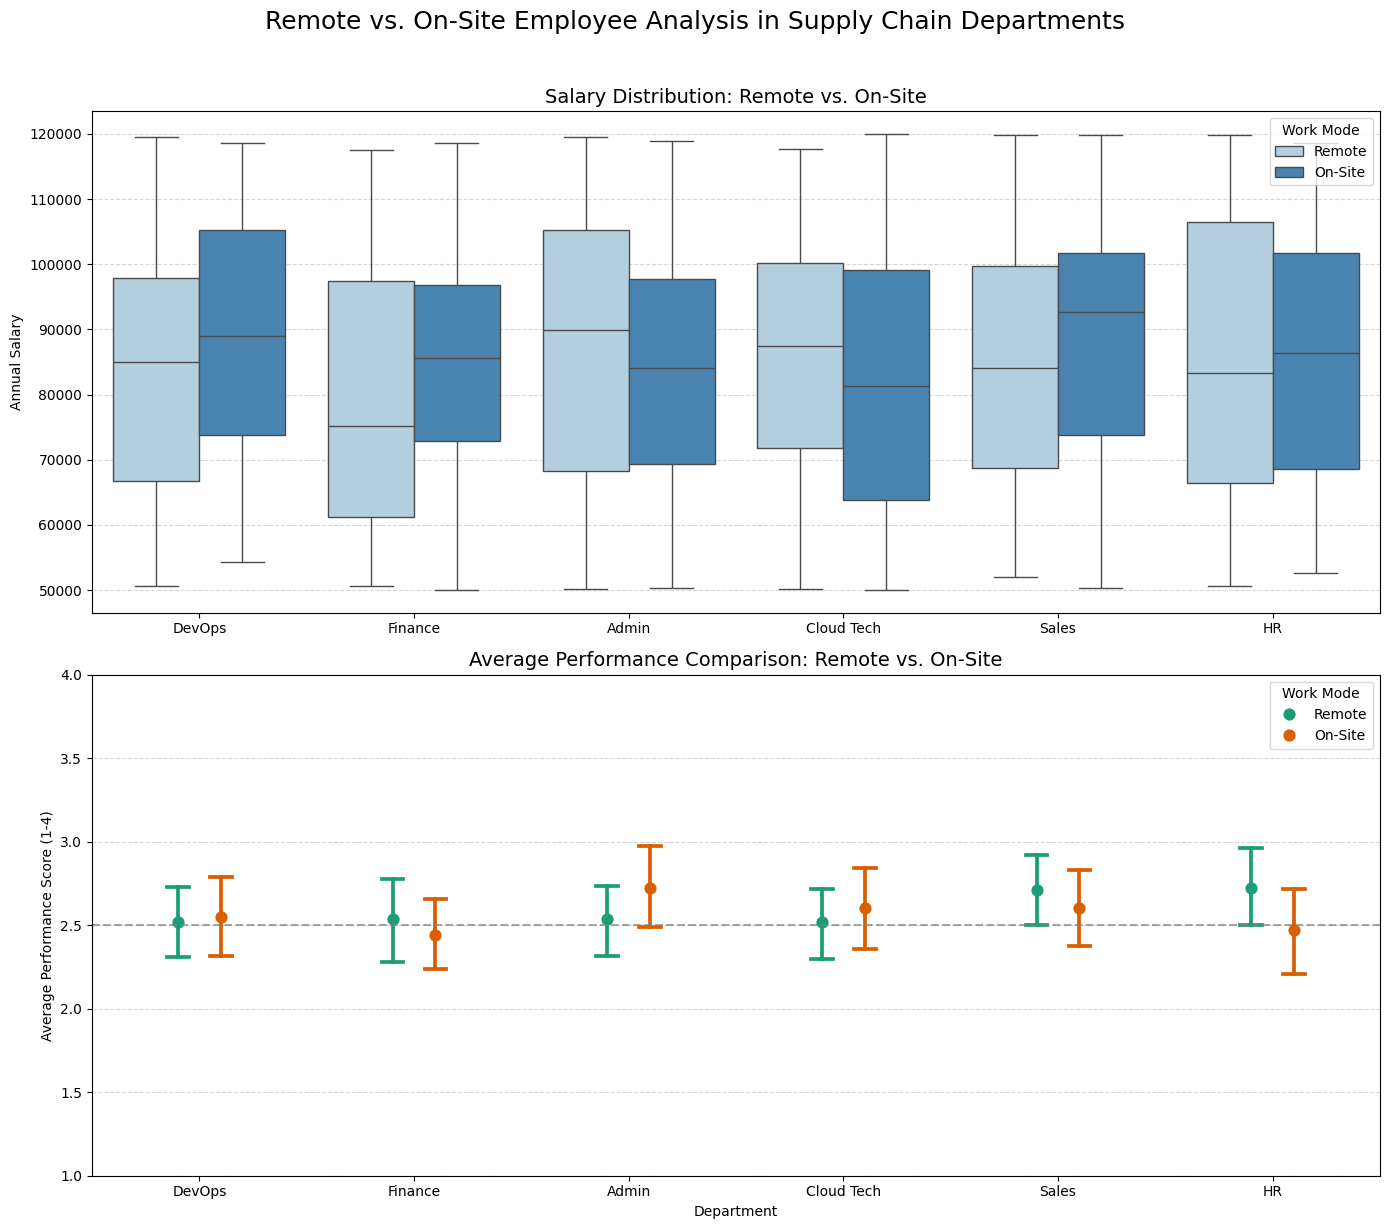

In [23]:
# --- 4.2 Visualization: Salary and Performance Comparison ---

# Create a figure with two subplots stacked vertically.
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle('Remote vs. On-Site Employee Analysis in Supply Chain Departments', fontsize=18, y=1.02)

# --- Plot 1: Salary Distribution ---
# A boxplot is used to compare the distribution of salaries between the two work modes.
sns.boxplot(
    data=remote_work_analysis_df,
    x='department',
    y='salary',
    hue='work_mode',
    palette='Blues',
    ax=axes[0]
)
axes[0].set_title('Salary Distribution: Remote vs. On-Site', fontsize=14)
axes[0].set_ylabel('Annual Salary')
axes[0].set_xlabel('') # X-axis label is shared, so it's removed here
axes[0].legend(title='Work Mode', loc='upper right')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Plot 2: Performance Comparison ---
# A pointplot is excellent for comparing mean values and their confidence intervals.
sns.pointplot(
    data=remote_work_analysis_df,
    x='department',
    y='performance_key',
    hue='work_mode',
    palette='Dark2',
    dodge=0.2,      # Separates the points for each hue
    join=False,     # Removes the connecting lines between categories
    capsize=0.1,    # Adds error bar caps for clarity
    ax=axes[1]
)
# Add a benchmark line for average performance.
axes[1].axhline(2.5, color='gray', linestyle='--', alpha=0.7)
axes[1].set_title('Average Performance Comparison: Remote vs. On-Site', fontsize=14)
axes[1].set_ylabel('Average Performance Score (1-4)')
axes[1].set_xlabel('Department')
axes[1].set_ylim(1, 4) # Set y-axis limits to the possible range of performance scores
axes[1].legend(title='Work Mode', loc='upper right')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()